In [50]:
from ragraph.io.esl import from_esl
graph = from_esl(["./esl"])

import raesl.plot
figure = raesl.plot.mdm(
    graph,
    node_kinds=["component"],
)
figure.write_image("figures/dsm_components.svg")
figure.show()

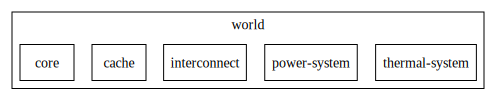

In [51]:
digraph = raesl.plot.functional_dependency_diagram(
    graph,
    root=graph["world"],
    levels=2,
)
digraph

In [52]:
figure = raesl.plot.mdm(
    graph,
    # node_kinds=["component", "variable", "function_spec", "design_spec", "relation_spec"],
    # edge_kinds=["functional_dependency", "mapping_dependency"],
    depth=2,
)
figure.write_image("figures/mdm.svg")
figure.show()

In [53]:
from ragraph.analysis import cluster

nodes, edges = multi_domain(
    graph,
    depth=4
)


relations = [n for n in nodes if n.kind == "relation_spec"]
variables = [n for n in nodes if n.kind == "variable"]

# Cluster components
cluster.tarjans_scc(
    graph=graph,
    leafs = variables + relations,
)

# Reloaded MDM based on clustered graph.
figure = raesl.plot.mdm(
    graph,
    # node_kinds=["component", "variable", "function_spec", "design_spec", "relation_spec"],
    # edge_kinds=["functional_dependency", "mapping_dependency"],
    depth=10,
)
figure.write_image("figures/mdm_clustered.svg")
figure

In [54]:
from ragraph.analysis import sequence
from raesl.plot.view_funcs import multi_domain
import ragraph.plot

# Select correct nodes and edges to be displayed.
nodes, edges = multi_domain(
    graph,
    depth=4
)

leaf_models = [n for n in nodes if n.kind == "relation_spec"]
leaf_vars = [n for n in nodes if n.kind == "variable"]

# Sequence functions.
_, _, sequenced_functions = sequence.utils.branchsort(algo=sequence.scc_tearing, graph=graph, algo_args=dict(inf=1, dep=1, mu=3), inplace=True, nodes=leaf_vars+leaf_models)

# Reload figure based on sequence.
figure = ragraph.plot.mdm(
    leafs = nodes,
    edges = edges,
    style= ragraph.plot.Style(
        piemap=dict(
            display="labels",
            mode="relative",
            fields=graph.edge_labels
        ),
    )
)

figure.write_image("figures/mdm_sequenced.svg")
figure